## Лабораторна робота 2

In [1]:
import numpy as np
grades = [92, 100, 100, 85, 93, 93, 98, 100, 97, 98, 100, 85, 100, 85, 96, 100, 94, 87, 100, 94, 98, 95, 80, 95, 98, 95, 98, 80, 90, 96, 95]
grades = np.array(grades)
print(grades.mean())

94.09677419354838


Виконав Пушкар Максим, Статистика, Варіант 4

**Завдання:** 
1. Реалiзуйте алгоритм стохастичного градiєнтного спуску з фiксованим $\alpha$. Порiвняйте результати з теоретичними.

2. Реалiзуйте алгортим стохастичного градiєнтного спуску з використанням пакетiв (mini batch gradient descent) зi сталим $\alpha$. 

3. Реалiзуйте алгоритм оптимiзацiї Adam.

4. Порівняйте результати пунктів 1-3 між собою.

**Функція для тестування:**

Згенеруйте випадкову матрицю $X$ розмiрностi $50 \times 2$ з даними, де кожен рядок має нормальний розподiл 
iз середнiми $(−1,3)$, дисперсiями$(1,2)$ та коварiацiєю рiвною $0$. Згеренуйте $50 \times 1$ вектор $Y$ за формулою 
$ Y_i = 1_{3X_i^{(1)} + X_i^{(2)} + \varepsilon_i > 0 } $.
Тут $\varepsilon_i \sim N(0,0.1)$. В якостi цiльової функцiї для оптимiзацiї оберiть функцiю максимальної правдоподiбностi або перехресну ентропiю в логiстичнiй регресiї.

### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Target function definition

Це функція із 1-ї лабораторної роботи, просто випишемо все необхідне для неї:

In [2]:
np.random.seed(seed=42)    # для відтворюваності результатів

mu = np.array([-1, 3])
sigma_squared = np.array([1, 2])

X = np.random.normal(mu, sigma_squared, (50, 2))
eps = np.random.normal(0, 0.1, (50, 1))

Y = (3*X[:,0] + X[:,1] + eps.T > 0).astype(int)
Y = Y.reshape((-1, 1))

У першій лабораторній ми писати Loss та Loss_better, тут обмежимося лише другою, і будемо називати її Loss.

In [3]:
def Loss(Y, Y_hat):
    mask = Y == 0

    ans = 0
    ans -= np.sum(np.log(1 - Y_hat[mask]))
    ans -= np.sum(np.log(Y_hat[~mask]))

    return ans

Оскільки для SGD нам потрібно буде вміти рахувати Loss для одного елементу даних, перевіримо що це можна зробити в нашій реалізації

In [4]:
Loss([[1]], np.array([[10**(-30)]]))

69.07755278982137

З тих самих причин напишемо prediction для двох варіантів

In [5]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))


def prediction(W, X):
    w1, w2 = W

    try:
        x1, x2 = X[:, 0], X[:, 1]
    except IndexError:
        x1, x2 = X[0], X[1]

    Y_hat = sigmoid(w1 * x1 + w2 * x2).reshape([-1, 1])

    return Y_hat, x1, x2


def target(W, X, Y):
    Y_hat = prediction(W, X)[0]
    return Loss(Y, Y_hat)

Перевіримо, що все рахується правильно: порахуємо суму loss функцій для кожної точки, складемо, і впевнимося що це не відрізняється від розрахунку loss на всіх даних тією ж формулою.

In [6]:
ans = 0
for temp in range(50):
    ans += target([3,1], X[temp], Y[temp])

ans -= target([3,1], X, Y)
ans

1.7763568394002505e-15

In [7]:
def grad_target(W, X, Y):
    w1, w2 = W

    Y_hat, x1, x2 = prediction(W, X)

    Y_hat = sigmoid(w1 * x1 + w2 * x2)
    Y_hat = Y_hat.reshape([-1, 1])

    dw1 = -np.sum( x1.reshape([-1, 1]) * (Y * (1 - Y_hat) - (1 - Y) * Y_hat))
    dw2 = -np.sum( x2.reshape([-1, 1]) * (Y * (1 - Y_hat) - (1 - Y) * Y_hat))

    return np.array([dw1, dw2]).reshape([-1, 1])

In [8]:
ans = 0
for temp in range(50):
    ans += grad_target([3,1], X[temp], Y[temp])

ans -= grad_target([3,1], X, Y)
ans

array([[8.8817842e-16],
       [8.8817842e-16]])

### Methods

#### Code

Всі наступні алгоритми написані на базі відповідей ChatGPT, тим не менш із суттєвими змінами: https://chat.openai.com/share/25d0e26d-8306-4eea-81a2-f54adbd08d0a

Реалізуємо SGD та MBGD в одній функції. Випадковість будемо реалізовувати перемішуванням наших даних. Запам'ятовувати будемо лише значення коефіцієнтів, потім вже коли будемо малювати картинки будемо проганяти розрахунок повного target та grad_target. Це робиться для быльш точного порывняння алгоритмів в часі.

In [9]:
def stochastic_gradient_descent(grad_target, W, X, Y, learning_rate, num_epochs, batch_size=1):
    """
    Perform Stochastic Gradient Descent.

    Parameters:
    X: numpy array, input features
    y: numpy array, true labels
    W: numpy array, initial model parameters
    learning_rate: float, learning rate for gradient descent
    num_epochs: int, number of training epochs
    batch_size: int, size of mini-batch

    Returns:
    history: list, history of parameters
    """
    m = Y.shape[0]
    W_history = [W.flatten()]

    for epoch in range(num_epochs):
        # Shuffle the data
        permutation = np.random.permutation(m)
        X_shuffled = X[permutation]
        Y_shuffled = Y[permutation]


        for i in range(0, m, batch_size):
            xi = X_shuffled[i:i + batch_size]
            yi = Y_shuffled[i:i + batch_size]

            # Update the parameters
            gradient = grad_target(W, xi, yi)
            W -= learning_rate * gradient

            W_history.append(W.flatten())

    return W_history

ADAM реалізовуємо із тією ж самою філософією:

In [10]:
def adam_optimizer(grad_target, X, Y, W, learning_rate, num_epochs, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Perform ADAM optimization.

    Parameters:
    X: numpy array, input features
    y: numpy array, true labels
    W: numpy array, initial model parameters
    learning_rate: float, learning rate for gradient descent
    num_epochs: int, number of training epochs
    beta1: float, exponential decay rate for the first moment estimate
    beta2: float, exponential decay rate for the second moment estimate
    epsilon: float, small constant to prevent division by zero

    Returns:
    theta: numpy array, optimized model parameters
    cost_history: list, history of cost values during optimization
    """
    
    W_history = [W.flatten()]

    m_t = np.zeros_like(W)
    v_t = np.zeros_like(W)
    t = 0

    for epoch in range(num_epochs):
        gradients = grad_target(W, X, Y)

        t += 1

        m_t = beta1 * m_t + (1 - beta1) * gradients
        v_t = beta2 * v_t + (1 - beta2) * np.square(gradients)

        m_t_hat = m_t / (1 - beta1**t)
        v_t_hat = v_t / (1 - beta2**t)

        W -= learning_rate * m_t_hat / (np.sqrt(v_t_hat) + epsilon)

        W_history.append(W.flatten())

    return W_history

Нижче функція для генерації картинок за історією алгоритму. Спершу ми рахуємо значення функцій та норми градієнтів, а потім відмальовуємо їх в заданій області (можна звузити за допомогою data_slice для кращої візуалізації конкретних місць алгоритму). На 2 та 3 графіку повний стохастичний графік, і графік cumulative minimum для зображення динаміки. На 1му графіку просто наведено значення $W$

In [11]:
def plot_graphs(history, target, grad_target, X, Y, log_scale=False, data_slice=None):
    W_history = history

    value_history = []
    grad_history = []

    for W in W_history:
        W = W.reshape((-1, 1))
        
        value_history.append(target(W, X, Y))
        grad_history.append(np.linalg.norm(grad_target(W, X, Y)))


    if data_slice is not None:
        value_history, grad_history, W_history = np.array(value_history), np.array(grad_history), np.array(W_history)
        value_history, grad_history, W_history = value_history[data_slice], grad_history[data_slice], W_history[data_slice]
    else:
        data_slice = np.arange(0, len(value_history), 1)


    plt.rcParams.update({'font.size': 20})

    fig, ax = plt.subplots(1, 3, figsize=(30, 7))

    ax_x = ax[0]
    ax_f = ax[1]
    ax_grad = ax[2]

    ax_x.scatter(*np.array(W_history).T, s=1)
    ax_x.set_title("Argument convergence")
    # ax_x.set_xlabel(r"$k$")
    # ax_x.legend([r"$\|\| x_k - x_{ans} \|\|$"])


    ax_f.plot(data_slice, value_history)
    ax_f.plot(data_slice, np.minimum.accumulate(value_history))
    # ax_f.plot(data_slice, np.cumsum(value_history)/(data_slice + 1))
    ax_f.set_xlabel(r"$k$")
    # ax_f.set_ylabel(r"$f(x_k) - f(x_{ans})$")
    ax_f.legend([r"$f(W_k)$"])
    ax_f.set_title("Function values")


    ax_grad.plot(data_slice, grad_history)
    ax_grad.plot(data_slice, np.minimum.accumulate(grad_history))
    ax_grad.set_xlabel(r"$k$")
    ax_grad.legend([r"$\|\| \nabla f(W_k) \|\| $"])
    ax_grad.set_title("Gradient norm")


    if log_scale:    
        ax_grad.set_yscale("log")
        ax_f.set_yscale("log")

    W_best = W_history[np.argmin(value_history)]
    print(f"Best achieved value {np.min(value_history):.5f} in the point {W_best.flatten()}")

    plt.show()

    return W_best

Використовується для того, щоб візуалізувати поведінку декількох алгоритмів на одному графіку.

In [12]:
def plot_mins(histories, legend, target, grad_target, X, Y, log_scale=False):
    plt.rcParams.update({'font.size': 20})

    fig, ax = plt.subplots(1, 2, figsize=(30, 7))

    ax_f = ax[0]
    ax_grad = ax[1]

    ax_f.set_xlabel(r"$k$")
    ax_f.set_title("Function values")

    ax_grad.set_xlabel(r"$k$")
    ax_grad.set_title("Gradient norm")

    if log_scale:    
        ax_grad.set_yscale("log")
        ax_f.set_yscale("log")


    for W_history in histories:
        value_history = []
        grad_history = []

        for W in W_history:
            W = W.reshape((-1, 1))
        
            value_history.append(target(W, X, Y))
            grad_history.append(np.linalg.norm(grad_target(W, X, Y)))

        ax_f.plot(np.minimum.accumulate(value_history))
        ax_grad.plot(np.minimum.accumulate(grad_history))

    ax_f.legend(legend)
    ax_grad.legend(legend)

    plt.show()

#### SGD with fixed $\alpha$

Всі 3 алгоритми будемо проганяти з однієї і тій ж самої початкової точци $(0, 0)$. Значення кількості епох обрано так, щоб займати 0.5 секунд (для кожного алгоритму) на моєму комп'ютері. Так ми зможемо потім порівнювати в часі який алгоритм працює краще. Тепер порівняємо learning rate

In [13]:
history_SGD_01 = stochastic_gradient_descent(grad_target, W=np.array([[0.0], [0.0]]), X=X, Y=Y, 
                                              learning_rate=0.1, num_epochs=500)

Best achieved value 2.49113 in the point [15.15011594  5.0418313 ]


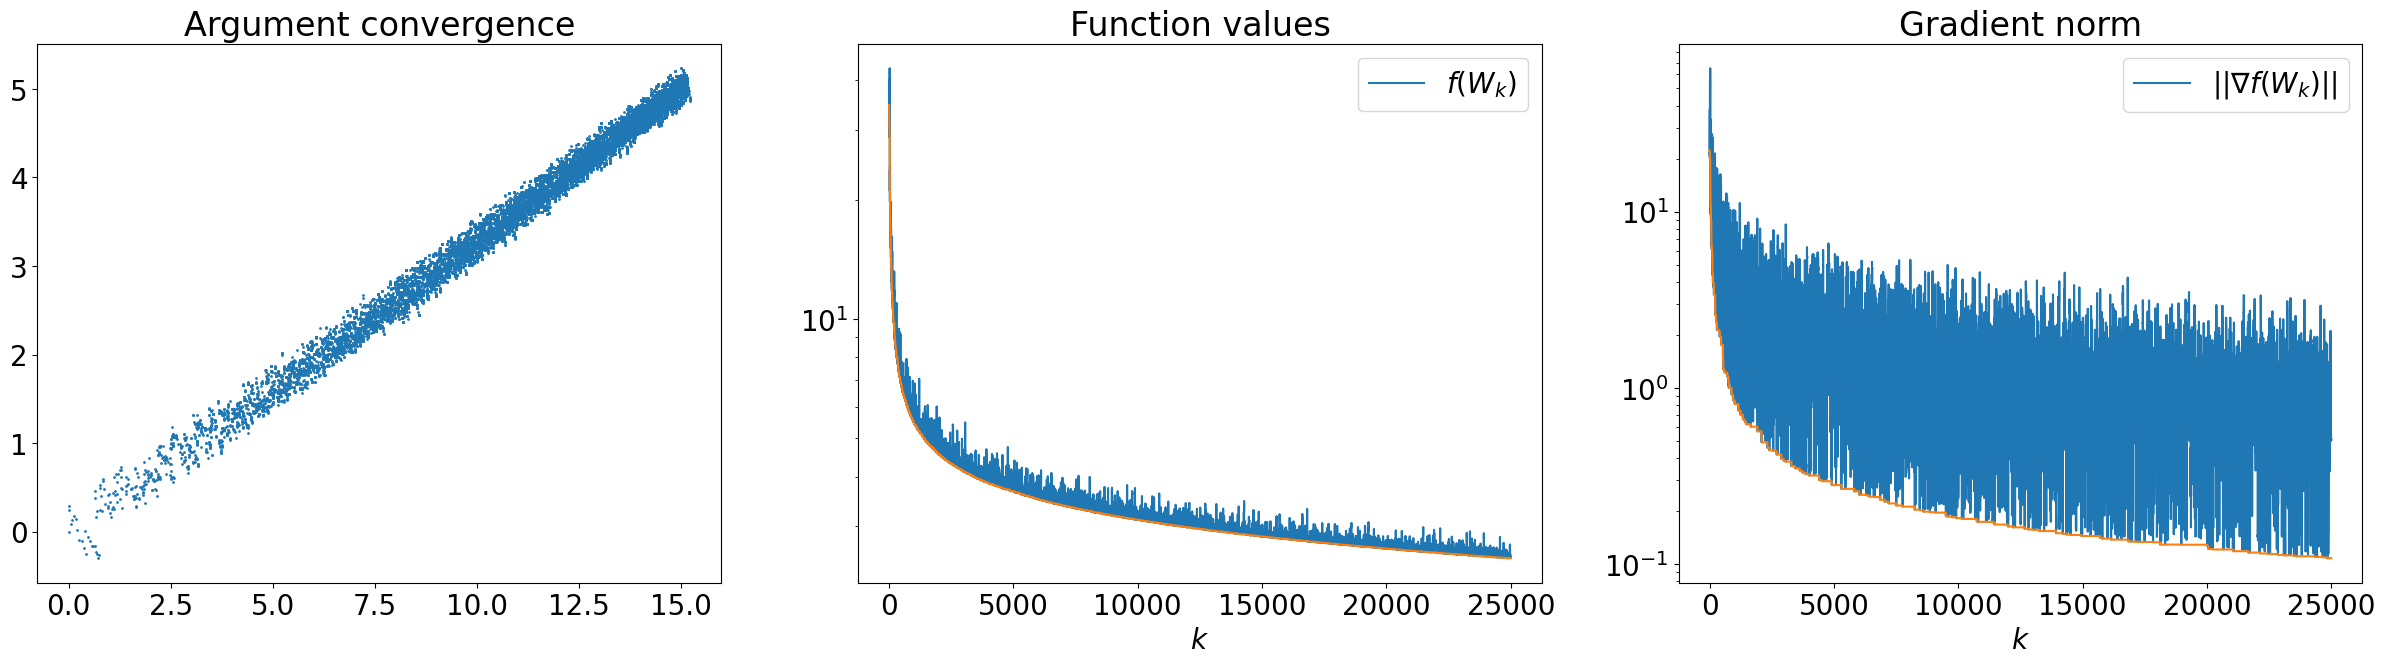

In [14]:
W_best = plot_graphs(history_SGD_01, target, grad_target, X=X, Y=Y, log_scale=True, data_slice=None)

In [15]:
history_SGD_02 = stochastic_gradient_descent(grad_target, W=np.array([[0.0], [0.0]]), X=X, Y=Y, 
                                              learning_rate=0.2, num_epochs=500)

Best achieved value 2.00772 in the point [20.56332328  6.91945266]


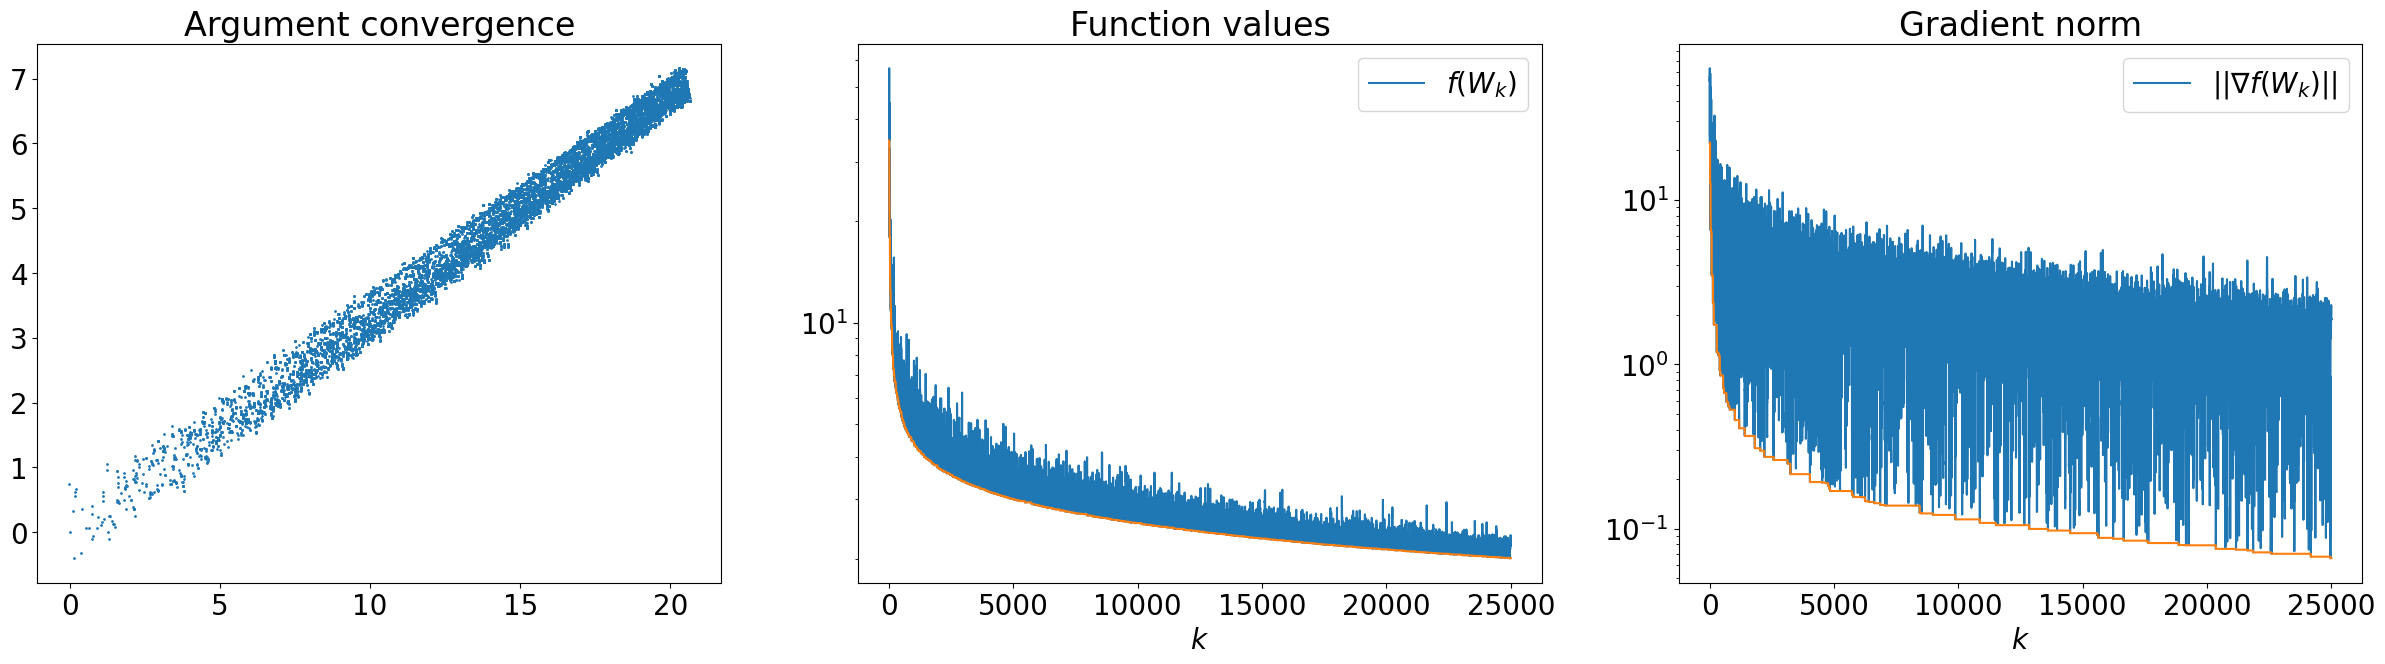

In [16]:
W_best = plot_graphs(history_SGD_02, target, grad_target, X=X, Y=Y, log_scale=True, data_slice=None)

In [17]:
history_SGD_05 = stochastic_gradient_descent(grad_target, W=np.array([[0.0], [0.0]]), X=X, Y=Y, 
                                              learning_rate=0.5, num_epochs=500)

Best achieved value 1.44001 in the point [33.99011847 11.53121611]


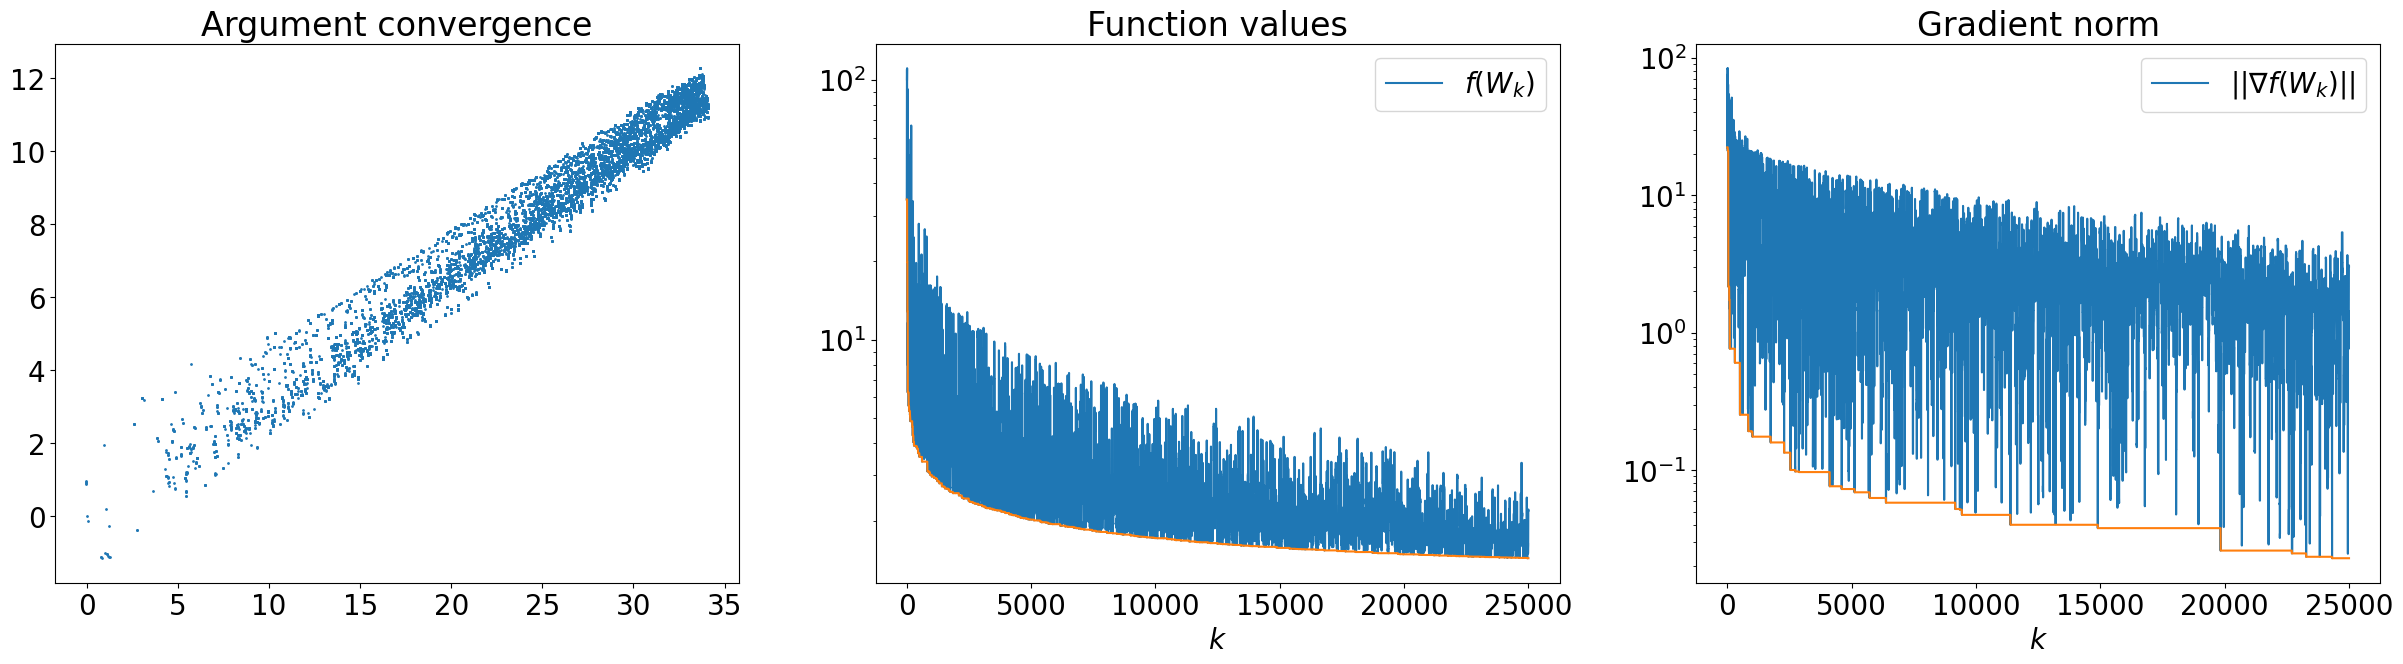

In [18]:
W_best = plot_graphs(history_SGD_05, target, grad_target, X=X, Y=Y, log_scale=True, data_slice=None)

In [22]:
history_SGD_09 = stochastic_gradient_descent(grad_target, W=np.array([[0.0], [0.0]]), X=X, Y=Y, 
                                              learning_rate=0.9, num_epochs=500)

Best achieved value 1.24937 in the point [51.45731211 17.43438741]


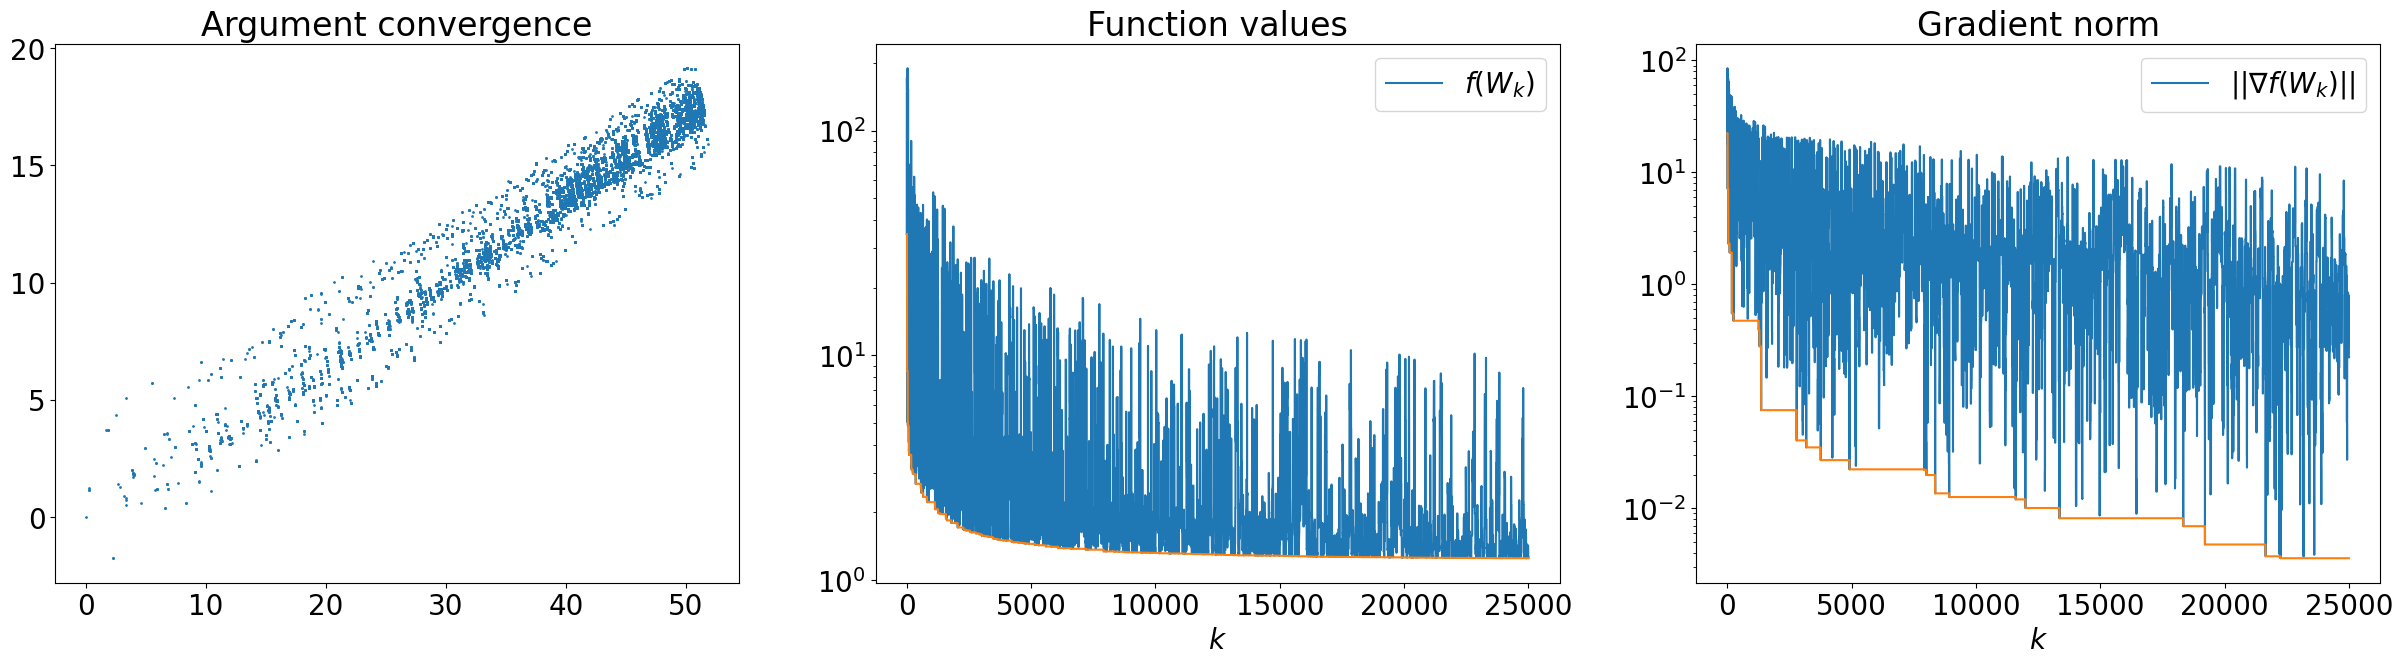

In [23]:
W_best = plot_graphs(history_SGD_09, target, grad_target, X=X, Y=Y, log_scale=True, data_slice=None)

Бачимо, що зі збільшенням learning rate ми отримуємо більшу дисперсію всього (значень функції, параметрів, норми градієнта). Особливо гарно видно на графіку градієнта, що той гарний мінімум, який зменшується зі збільшенням learning rate, сам досягається дуже рядко. Так само видно на графыку значень $W$, що розкид збільшуєтсья із збільшенням learning rate.

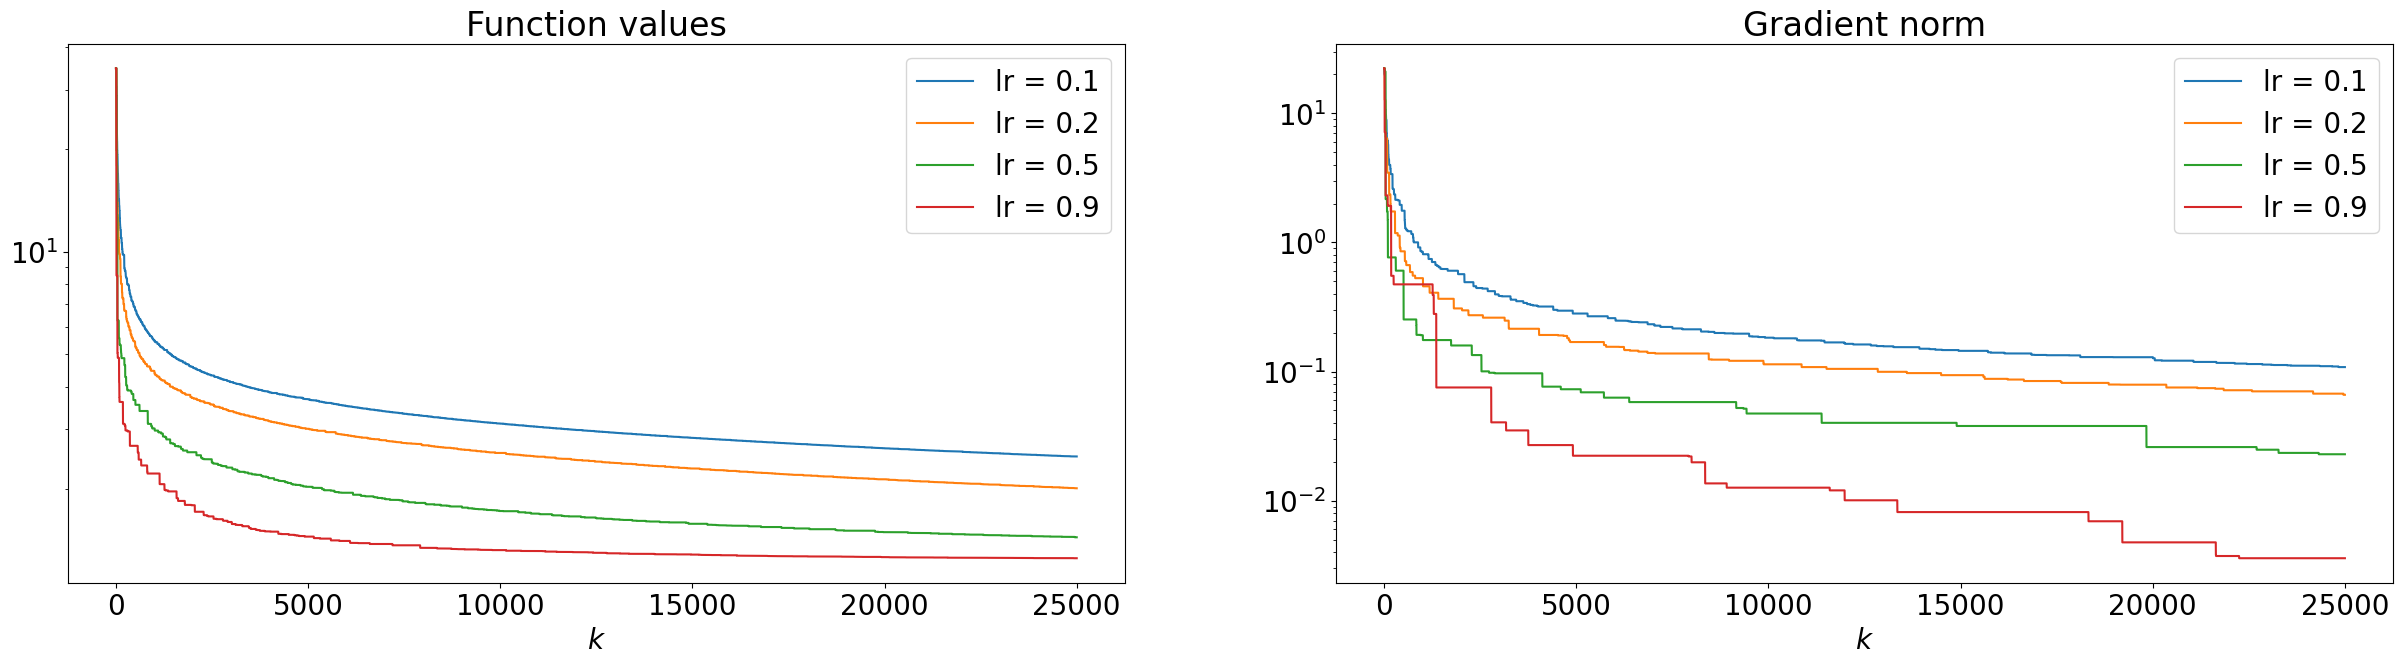

In [25]:
plot_mins([history_SGD_01, history_SGD_02, history_SGD_05, history_SGD_09], ["lr = 0.1", "lr = 0.2", "lr = 0.5", "lr = 0.9"], 
          target, grad_target, X=X, Y=Y, log_scale=True)

Зупинимося на значенні $0.25$ для подальшого порівняння з іншими алгоритмами.

In [26]:
history_SGD = stochastic_gradient_descent(grad_target, W=np.array([[0.0], [0.0]]), X=X, Y=Y, 
                                              learning_rate=0.25, num_epochs=500)

Best achieved value 1.86327 in the point [22.8357681   7.70577956]


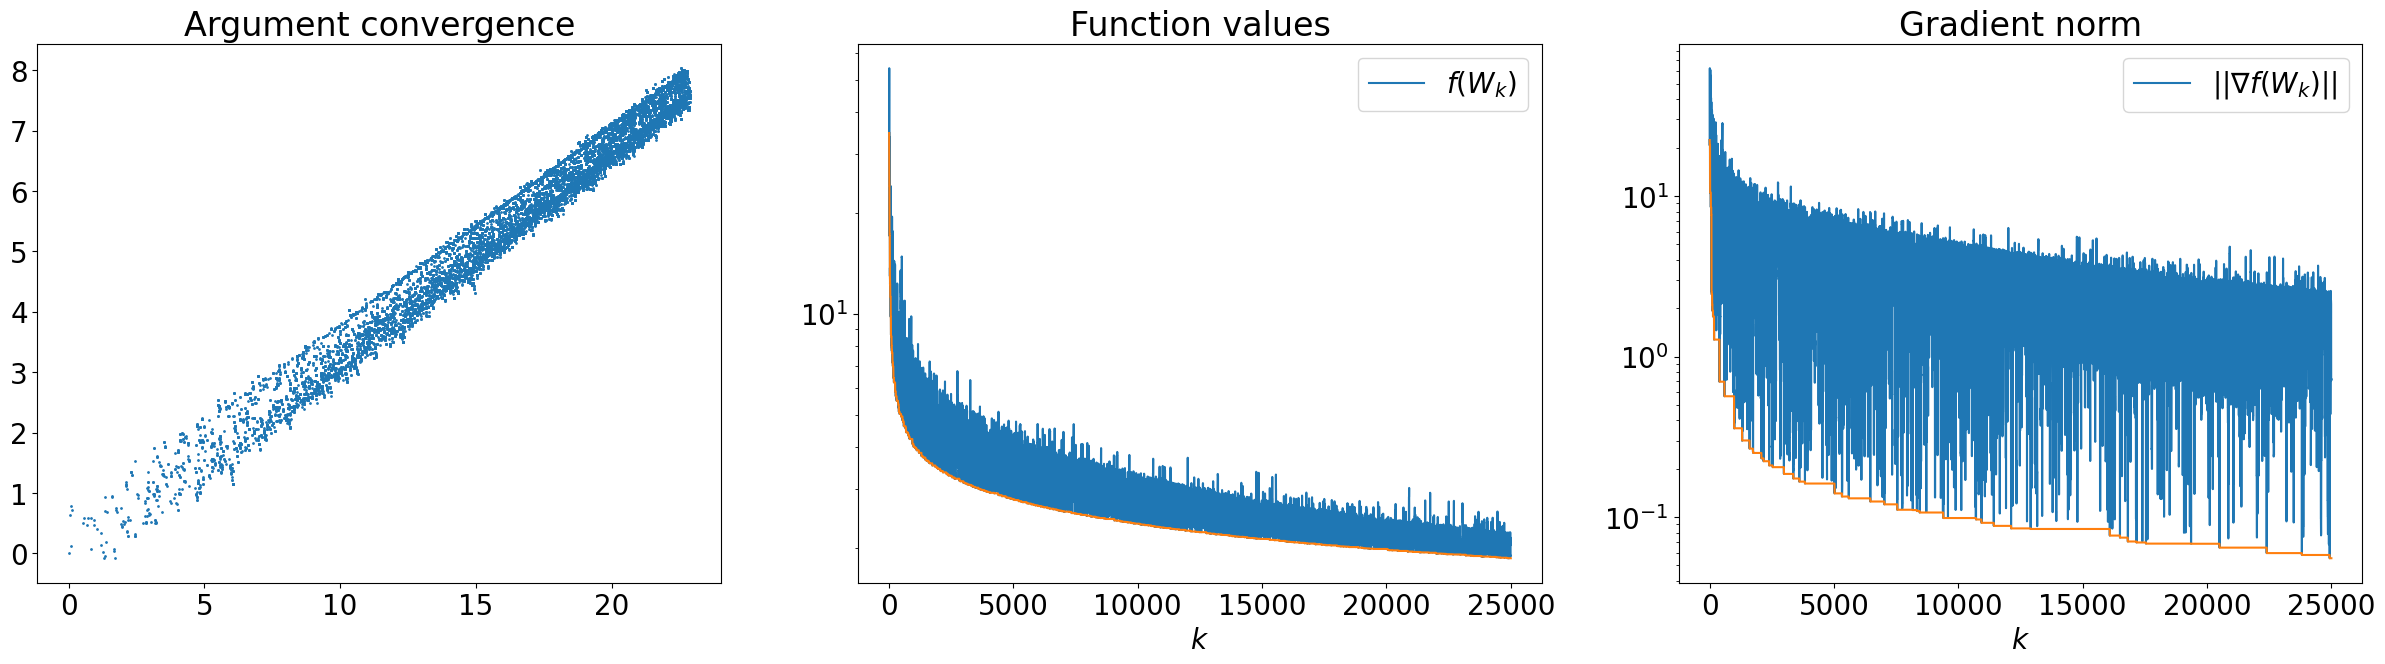

In [27]:
W_best = plot_graphs(history_SGD, target, grad_target, X=X, Y=Y, log_scale=True, data_slice=None)

Best achieved value 2.12757 in the point [19.01122473  6.35386536]


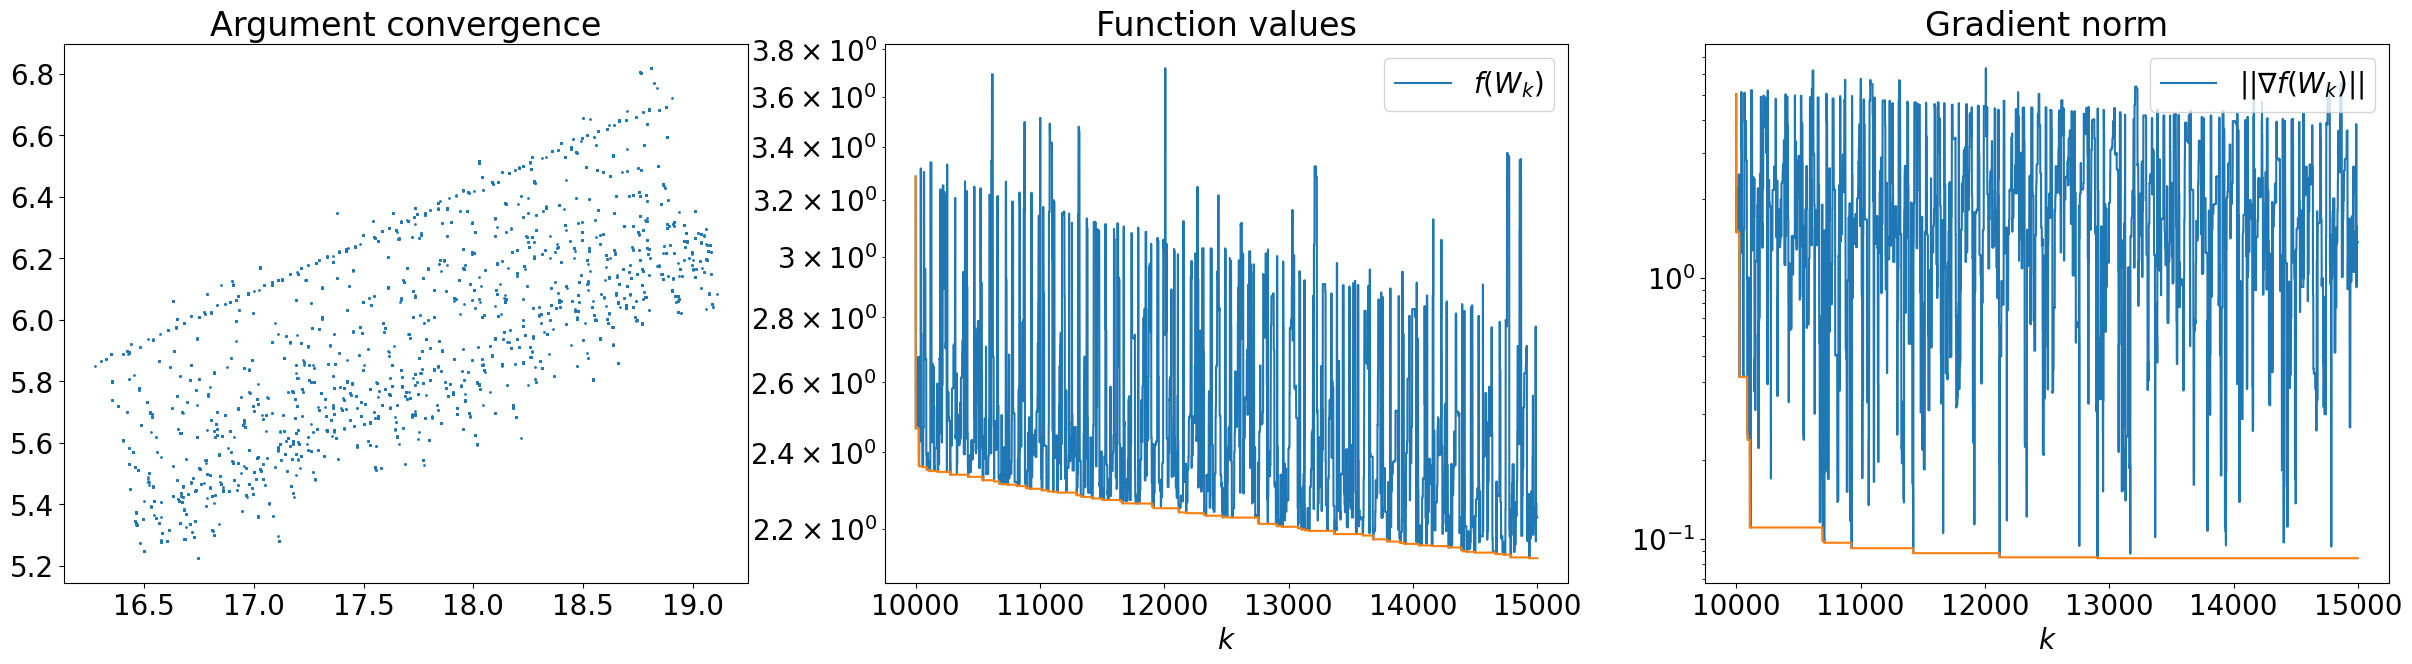

In [29]:
_ = plot_graphs(history_SGD, target, grad_target, X=X, Y=Y, log_scale=True, data_slice=np.arange(10000, 15000, 1))

In [28]:
w1, w2= W_best

print(f"Ratio if coefficients w1 and w2 is {w1/w2:.3f} which is close to 3/1 = 3, and that should be expected." )

Y_pred = (w1 * X[:, 0] + w2 * X[:, 1] > 0).astype(int)
Y_pred = Y_pred.reshape((-1, 1))

print(f"The number of incorrectly labeled is {np.sum(np.abs(Y - Y_pred))} (out of 50).")

Ratio if coefficients w1 and w2 is 2.963 which is close to 3/1 = 3, and that should be expected.
The number of incorrectly labeled is 1 (out of 50).


#### MBGD with fixed $\alpha$

Оберемо тут batch_size=16 без особливих міркувань, просто для прикладу. Як завжди, кількість епох обрана так, щоб час виконання був 0.5 с.

In [34]:
history_MBGD = stochastic_gradient_descent(grad_target, W=np.array([[0.0], [0.0]]), X=X, Y=Y, 
                                              learning_rate=0.25, num_epochs=4500, batch_size=16)

Best achieved value 1.28780 in the point [44.32489876 15.03524563]


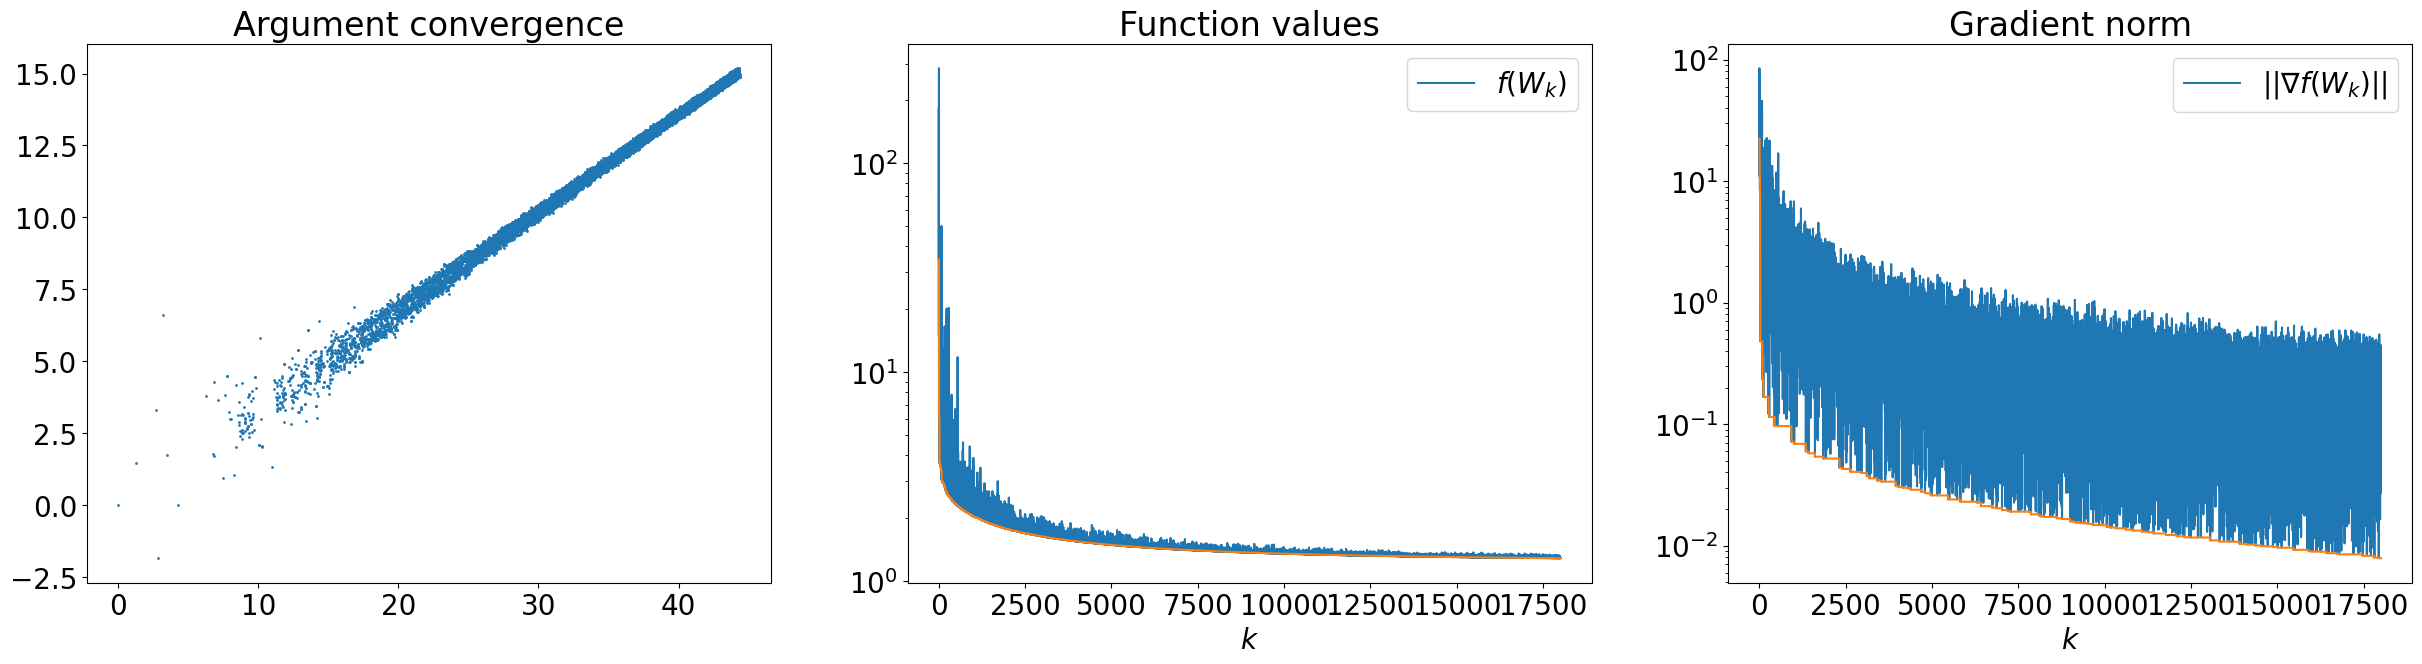

In [35]:
W_best = plot_graphs(history_MBGD, target, grad_target, X=X, Y=Y, log_scale=True)

Best achieved value 1.32880 in the point [40.38068058 13.6910415 ]


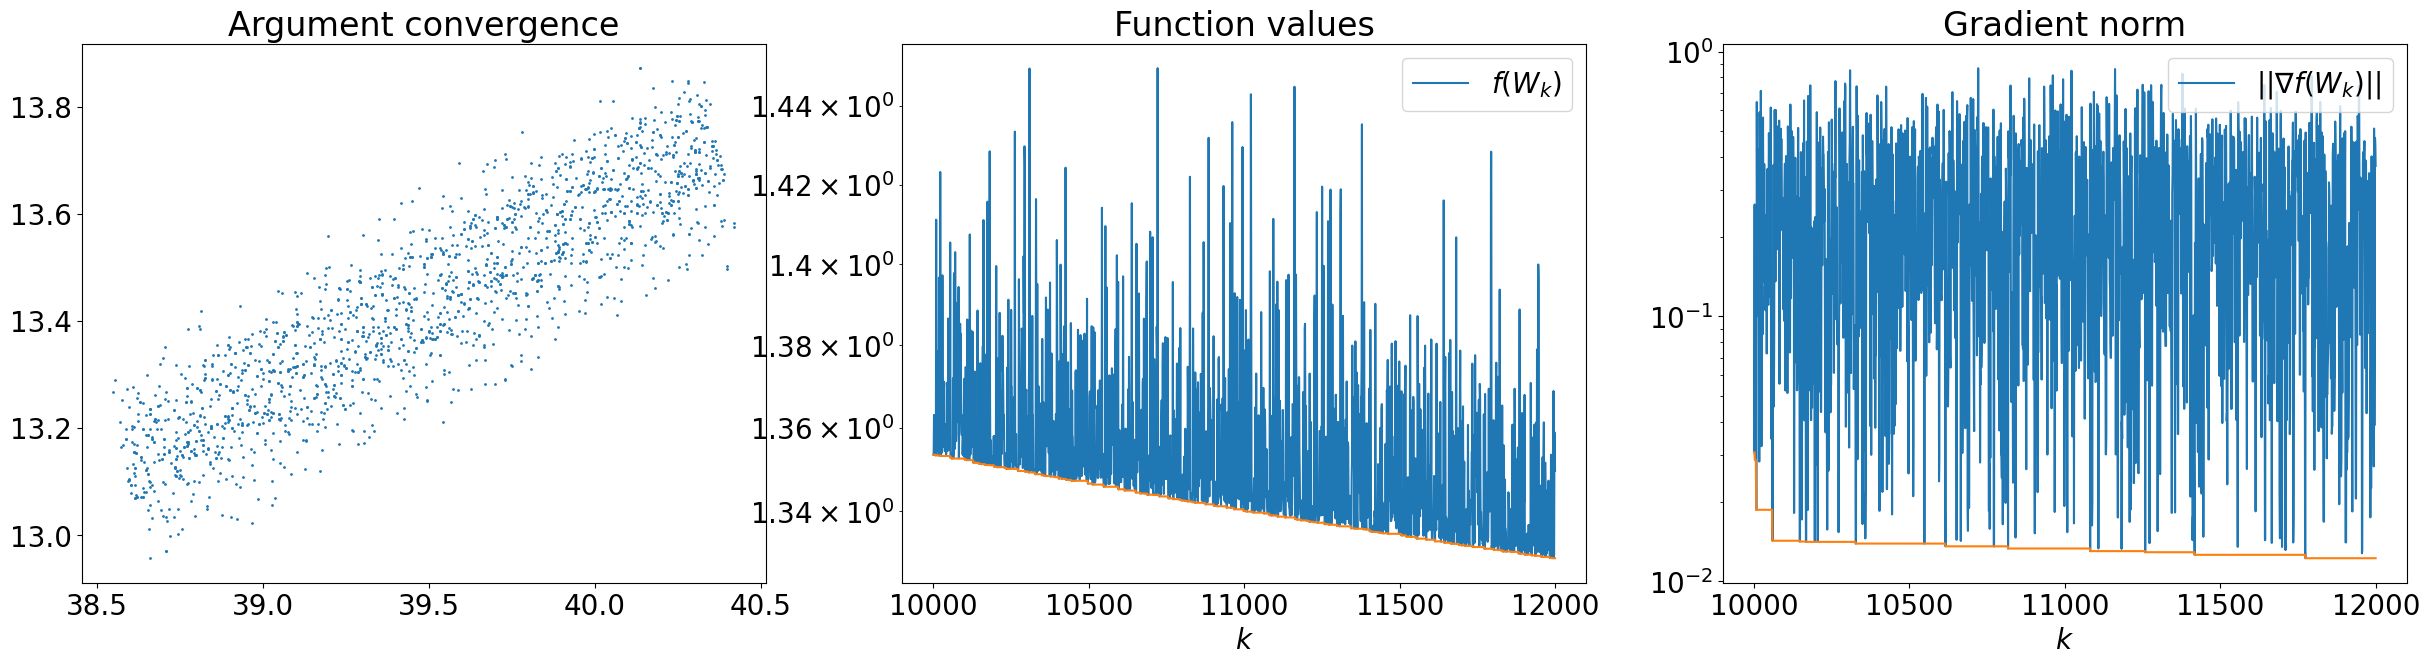

In [36]:
_ = plot_graphs(history_MBGD, target, grad_target, X=X, Y=Y, log_scale=True, data_slice=np.arange(10000, 12000, 1))

Одразу cходу бачимо багато плюсів. За той самий час на тому самому learning rate маємо на порядок меншу варіацію, менше значення цільової функції. 
Також, насправді, алгоритм працює швидше за SGD. Дійсно, ми маємо 18000 значень, кожне із яких вимагало обрахунку 16 градієнтів функції loss від одного елементу даних, що еквівалентно 288000 обрахункам градієнта. А в SGD за цей же час ми поріхували всього 25000. Паралелізації ні на CPU ні на GPU ми не робили, тут за пришвидження відповідає векторизація градієнта. B SGD ми використовуємо цикл for, а для обрахунку градієнта для MBGD використовуємо numpy, який має під капотом C\C++.

In [37]:
w1, w2= W_best

print(f"Ratio if coefficients w1 and w2 is {w1/w2:.3f} which is close to 3/1 = 3, and that should be expected." )

Y_pred = (w1 * X[:, 0] + w2 * X[:, 1] > 0).astype(int)
Y_pred = Y_pred.reshape((-1, 1))

print(f"The number of incorrectly labeled is {np.sum(np.abs(Y - Y_pred))} (out of 50).")

Ratio if coefficients w1 and w2 is 2.948 which is close to 3/1 = 3, and that should be expected.
The number of incorrectly labeled is 1 (out of 50).


#### ADAM

In [42]:
history_ADAM = adam_optimizer(grad_target, X, Y, W=np.array([[0.0], [0.0]]), learning_rate=0.1, num_epochs=15000)

Best achieved value 1.23986 in the point [58.32955739 19.70796663]


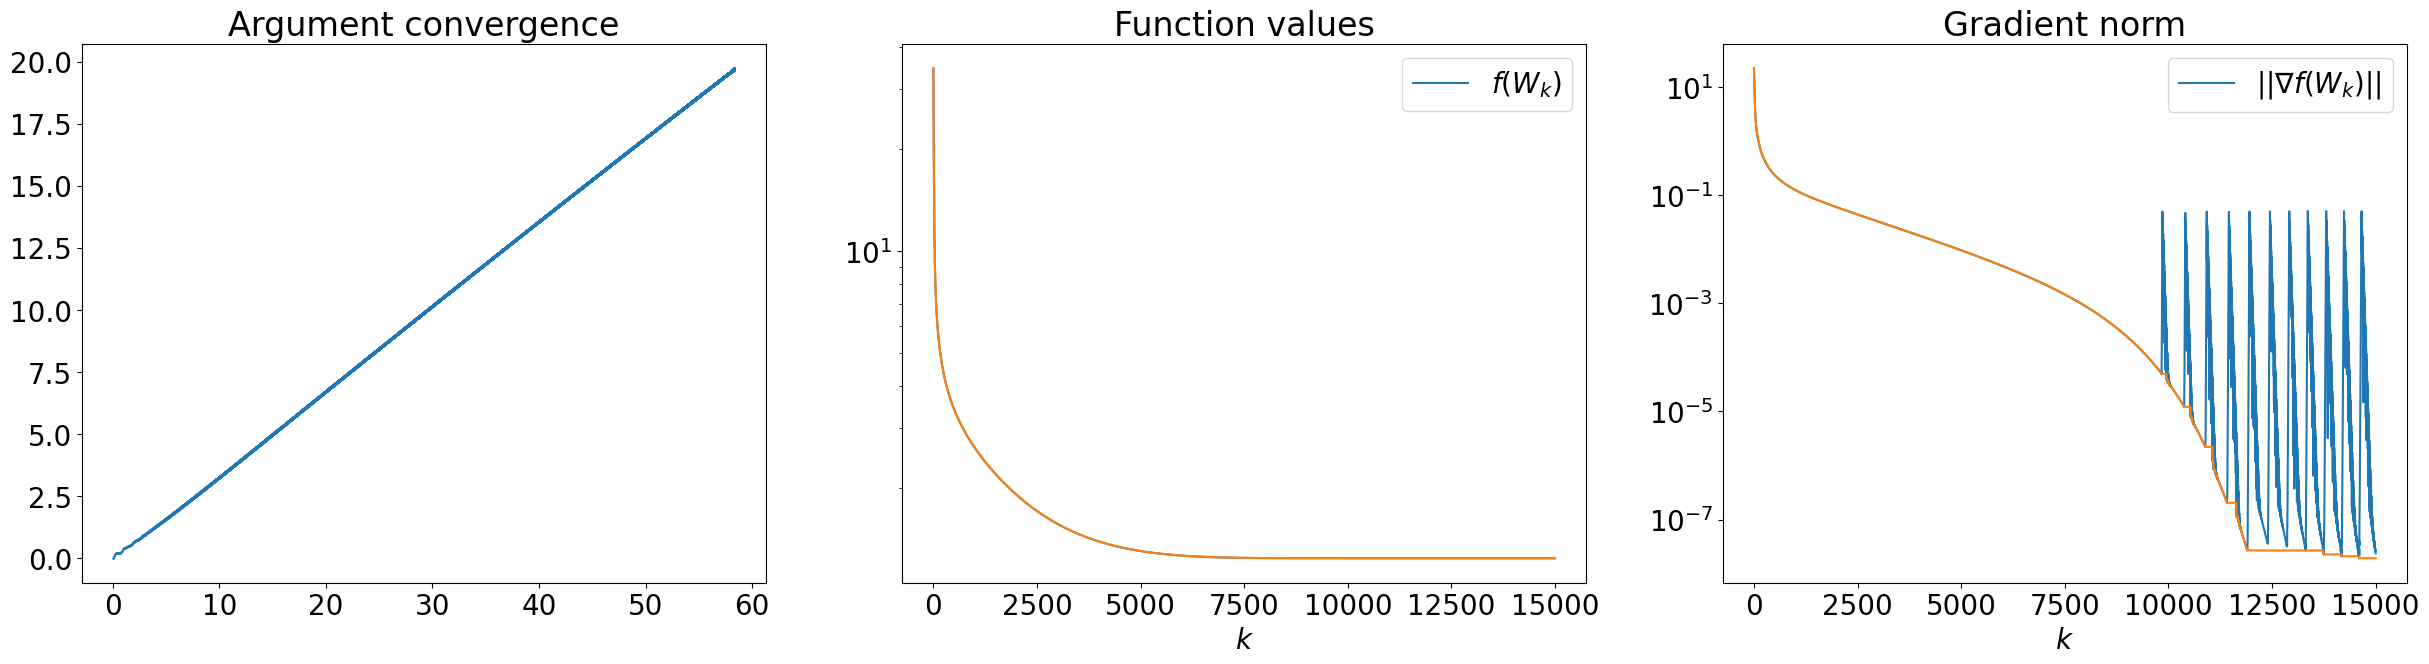

In [43]:
W_best = plot_graphs(history_ADAM, target, grad_target, X, Y, log_scale=True, data_slice=None)

Очевидно на порядок краще обох попередніх алгоритмів. Дисперсія значень функції практично неістотня, значення функції краще за обидва попередніх алгоритми, і це без жодного тюнінгу параметрів.

Щодо ефектів, що виникають на великих ітераціях, якщо поглянути на них детальніше, вони вносять мінімальну похидку в значення цільової функції (на відміну від попередніх алгоритмів)

Best achieved value 1.23986 in the point [58.32958632 19.70797656]


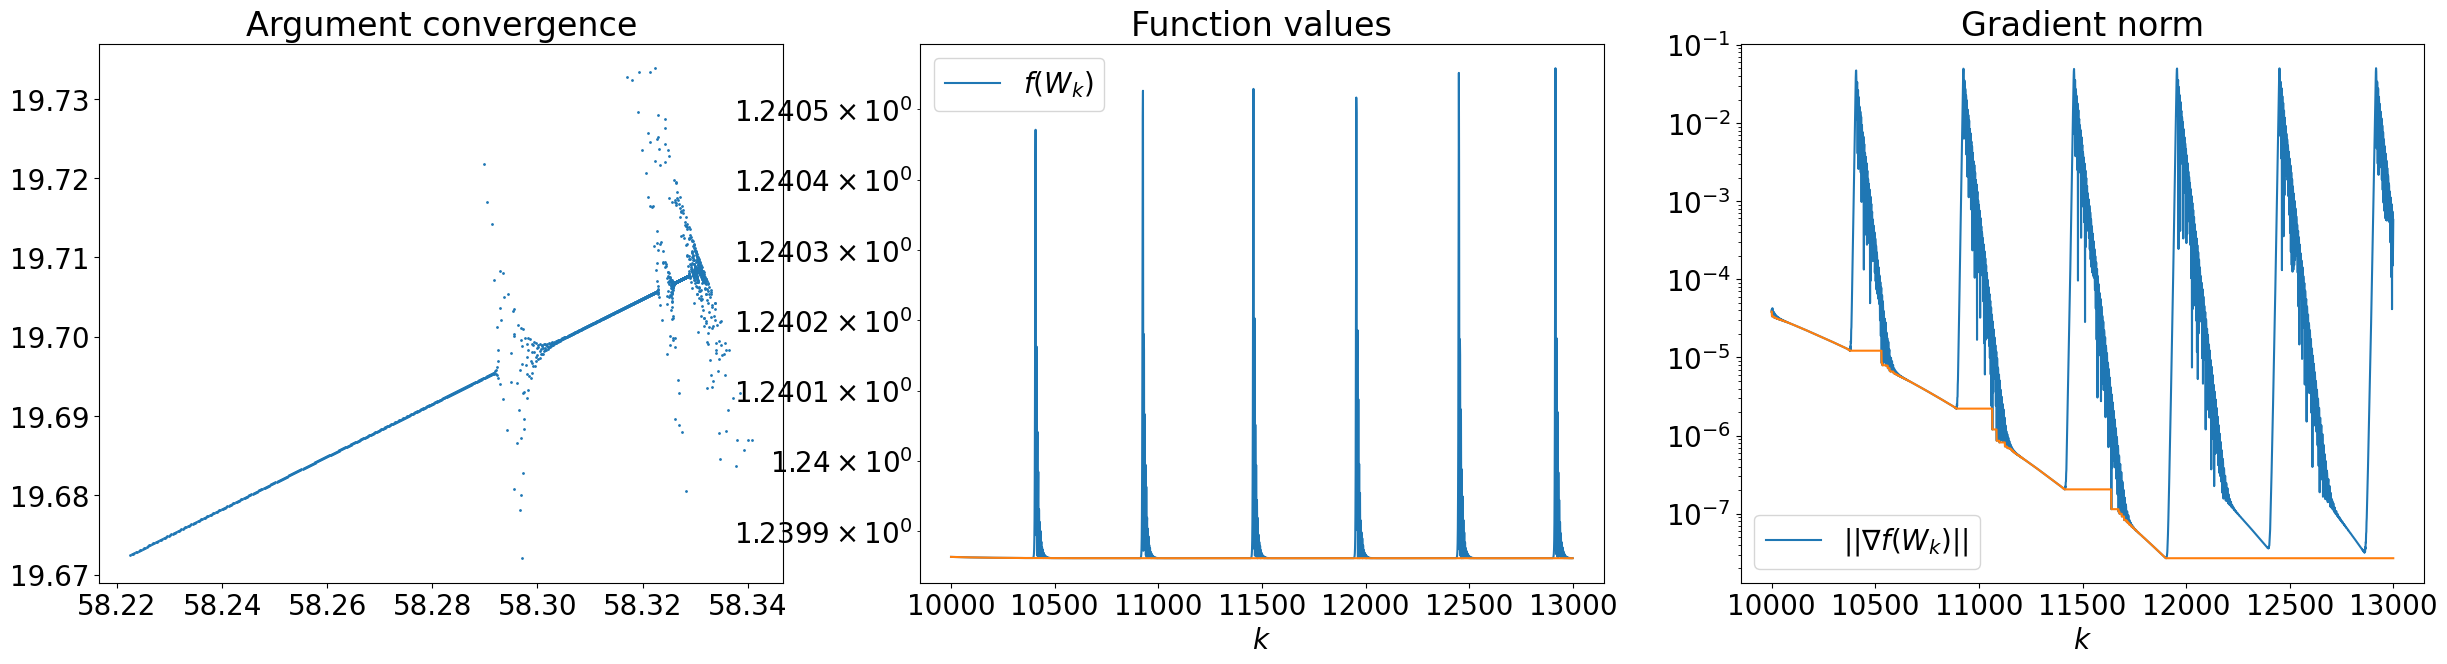

In [47]:
_ = plot_graphs(history_ADAM, target, grad_target, X, Y, log_scale=True, data_slice=np.arange(10000, 13000, 1))

In [48]:
w1, w2= W_best

print(f"Ratio if coefficients w1 and w2 is {w1/w2:.3f} which is close to 3/1 = 3, and that should be expected." )

Y_pred = (w1 * X[:, 0] + w2 * X[:, 1] > 0).astype(int)
Y_pred = Y_pred.reshape((-1, 1))

print(f"The number of incorrectly labeled is {np.sum(np.abs(Y - Y_pred))} (out of 50).")

Ratio if coefficients w1 and w2 is 2.960 which is close to 3/1 = 3, and that should be expected.
The number of incorrectly labeled is 1 (out of 50).


### Summary

Всі три алгоритми дають лише один міскрасифікований елемент. Поглянемо на графіки трьох разом:

In [51]:
histories = [history_SGD, history_MBGD, history_ADAM]

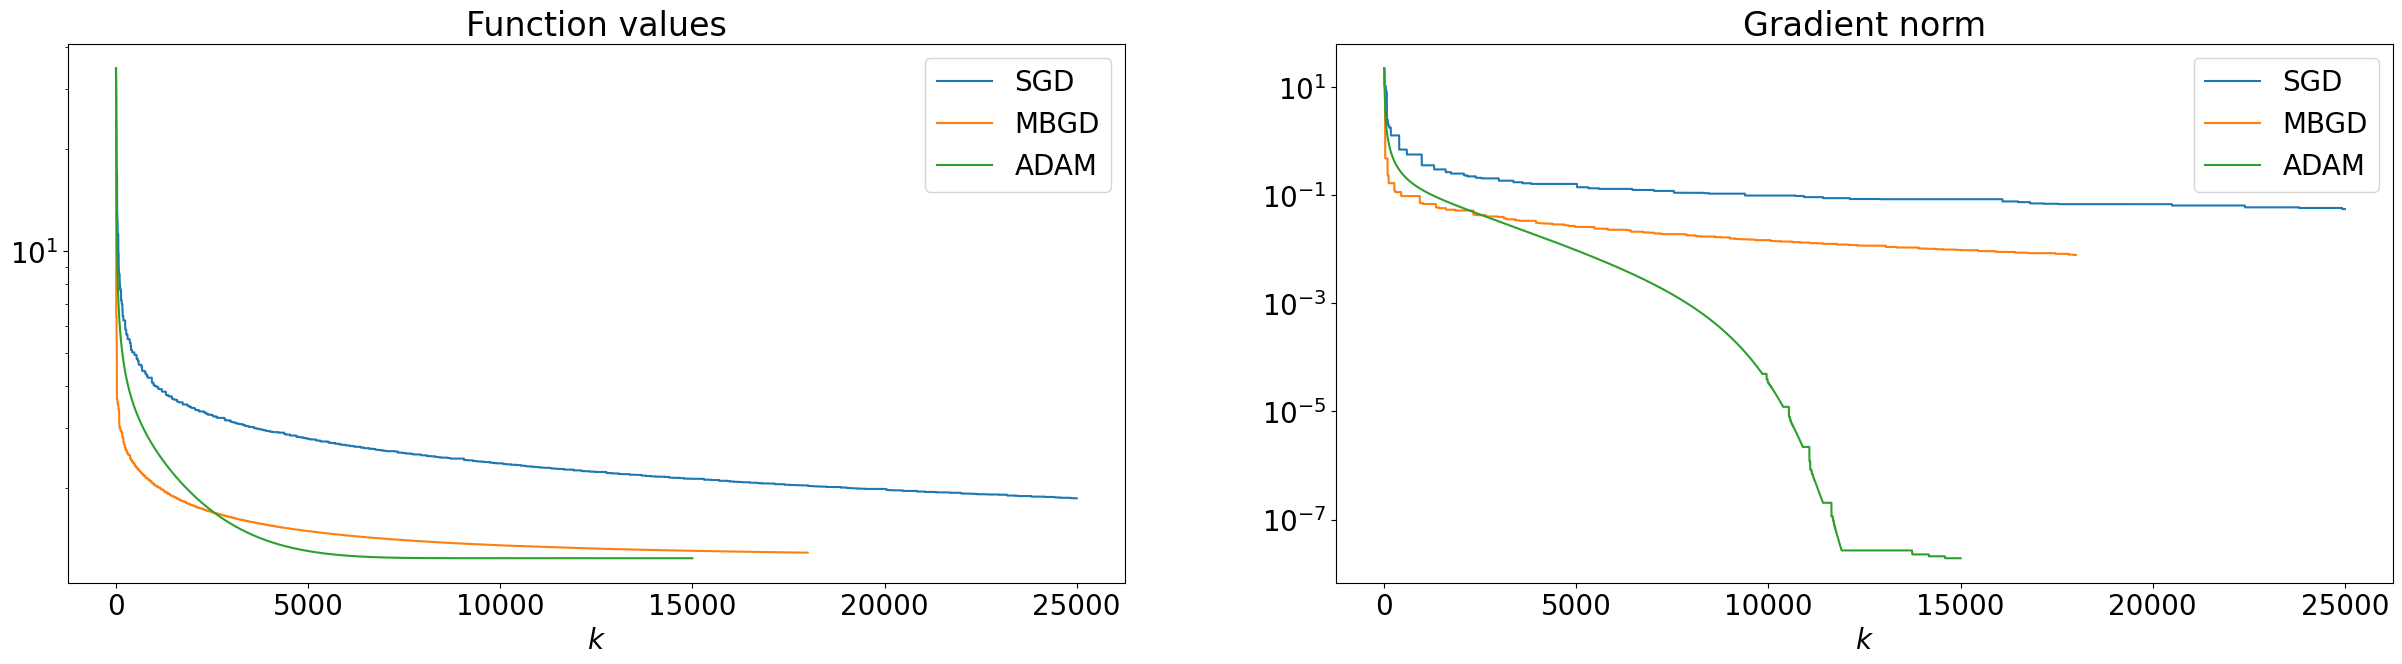

In [52]:
plot_mins(histories, ["SGD", "MBGD", "ADAM"], target, grad_target, X, Y, log_scale=True)

Бачимо, що оптимальним вийшов ADAM (навіть без тюнингу параметрів). Найгірним виявився SGD, а MBGD може конкурувати із ADAMом з практичної точки зору, адже на цій задачі MBGD перны 2500 ітерацій був нижче за ADAM, а на нашій задачі ми ще на попередній лабораторній роботі зрозумли, що навіть порівняно велике значення цільової функції може давати найкращу класифікацію із можливих, тому технічно MBGD міг би отримати результат на цій задачі на цих параметрах раніше. Але його велика зашумленість (як і SGD) несуть в собі велику проблему, адже ці малюнки ілюструють найменші значення, а як ми вже казали, для великих learning rates ми маємо дуже зашумлену картину, в якій більшість значень є далекими від мінімума.

Варто зауважити, що порівнювати результати оптимізації із теоритичними із лекцій складно, адже цільова функція не є строго опуклою, ы у нас занчення параметрів прямують на нескінченність, інакше кажучи у нас $c \to 0$ в умові строгої опуклості при розширенні області. До того ж складно оцінити мінімум нашої функції, а тому складно оцінити чи у нас є збіжність у SGD до мінімума, чи все-таки її немає і натомість є відділеність від нуля.